In [1]:
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
fp_data = "../results/bothterms_metrics_SM/"
FNs = glob.glob(fp_data+"*.tsv")
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    df_tmp["Train"] = df_tmp["method"].tolist()[0].split("-")[2]
    df_tmp["Test"] = df_tmp["method"].tolist()[0].split("-")[4]
    df_tmp["AddGenes"] = df_tmp["method"].tolist()[0].split("-")[0]
    df_results = pd.concat([df_results,df_tmp])
print(df_results.shape)
df_results.head()

(16253, 20)


,GSC_info,method,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,Train,Test,AddGenes
0,hs_sc__15_200_0.5_0.5,PosNegNoOrtho-Trn-hs-Tst-hs,IMP_raw,hs_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0000041,transition metal ion transport,48,8348,13,4174,0.370618,6.894781,0.829719,5,hs,hs,PosNegNoOrtho
1,hs_sc__15_200_0.5_0.5,PosNegNoOrtho-Trn-hs-Tst-hs,IMP_raw,hs_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0000280,nuclear division,103,8348,21,4174,0.037898,2.913161,0.702223,2,hs,hs,PosNegNoOrtho
2,hs_sc__15_200_0.5_0.5,PosNegNoOrtho-Trn-hs-Tst-hs,IMP_raw,hs_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0001510,RNA methylation,20,8348,19,4174,0.151406,5.055785,0.869998,4,hs,hs,PosNegNoOrtho
3,hs_sc__15_200_0.5_0.5,PosNegNoOrtho-Trn-hs-Tst-hs,IMP_raw,hs_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0003006,developmental process involved in reproduction,76,8348,48,4174,0.041266,1.843356,0.671872,3,hs,hs,PosNegNoOrtho
4,hs_sc__15_200_0.5_0.5,PosNegNoOrtho-Trn-hs-Tst-hs,IMP_raw,hs_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0005976,polysaccharide metabolic process,23,8348,17,4174,0.119555,4.875504,0.698567,3,hs,hs,PosNegNoOrtho


In [3]:
def make_plot2(network,features,task,figname):
    
    convert_dict = {"ce":"worm","dm":"fly","mm":"mouse","sc":"yeast","hs":"human"}
    
    if task == "mdl":
        myspecies = [["mm","hs_mm"],["dm","dm_hs"],["ce","ce_hs"],["sc","hs_sc"]]
        num_pans = 4
    elif task == "human":
        myspecies = [["hs","hs_mm","mm"],["hs","dm_hs","dm"],["hs","ce_hs","ce"],["hs","hs_sc","sc"]]
        num_pans = 4
    fig, ax = plt.subplots(1,num_pans,figsize=(14,6))
    for idx, item in enumerate(myspecies):  
        df_tmp = df_results[(df_results["network"]==network)&
                            (df_results["feature_type"].str.contains(features))&
                            (df_results["Test"]==item[0])&
                            ((df_results["AddGenes"]=="PosNegNoOrtho") | (df_results["AddGenes"]=="single"))&
                            (df_results["GSC_info"].str.contains(item[1]))]
    
        sns.boxplot(data=df_tmp,y="log2p",x="Train",hue="species",notch=True,showfliers=False,ax=ax[idx],
                    palette=["red","blue","orange"],hue_order=[item[0],item[1],"ce_dm_dr_hs_mm_sc"],
                    order=[item[0],item[1]])
#         ax[idx].legend(loc=2,title="Model Features")
        if idx == 0:
            ax[idx].set_ylabel("log2(auPRC/prior)",fontsize=10)
        else:
            ax[idx].set_ylabel("")
        ax[idx].set_xlabel("Genes Used in Training",fontweight="bold")
        if task == 'mdl':
            ax[idx].set_xticklabels([convert_dict[item[0]],f"{convert_dict[item[0]]}\n+\nhuman"])
            handles, labels = ax[idx].get_legend_handles_labels()
            ax[idx].legend(handles,[convert_dict[item[0]],f"{convert_dict[item[0]]}-human","All-species"],
                           loc=2,title="Model Features")
        elif task == "human":
            ax[idx].set_xticklabels(["human",f"human\n+\n{convert_dict[item[2]]}"])
            handles, labels = ax[idx].get_legend_handles_labels()
            ax[idx].legend(handles,["human",f"human-{convert_dict[item[2]]}","All-species"],
                           loc=2,title="Model Features")
    network2 = network.split("_")[0]
    if task == "mdl":
        fig.suptitle(f"Model Species Annotation Prediction - Network: {network2}",fontweight="bold",
                     fontsize=14,y=0.98)
    else:
        fig.suptitle(f"Human Annotation Prediction - Network: {network2}",fontweight="bold",
                     fontsize=14,y=0.98)   
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.2,top=0.9)
    fig.savefig(f"../figures/{figname}")

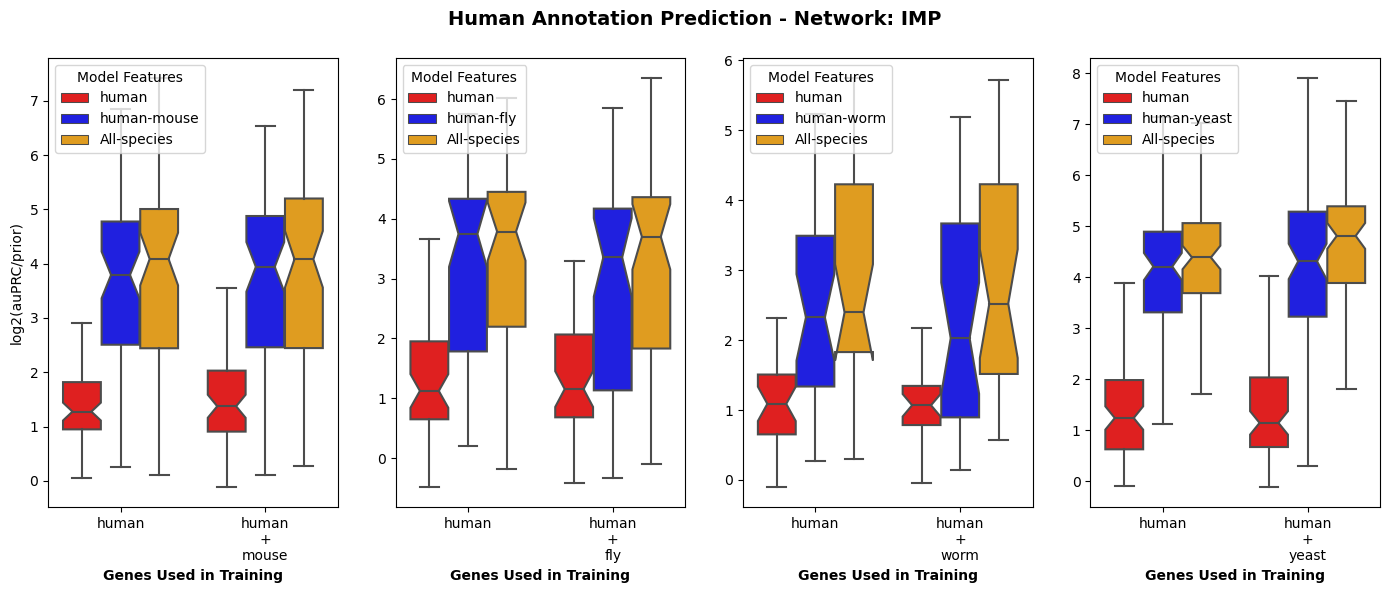

In [4]:
make_plot2("IMP_raw","Pecanpy","human","FigSM19.pdf")

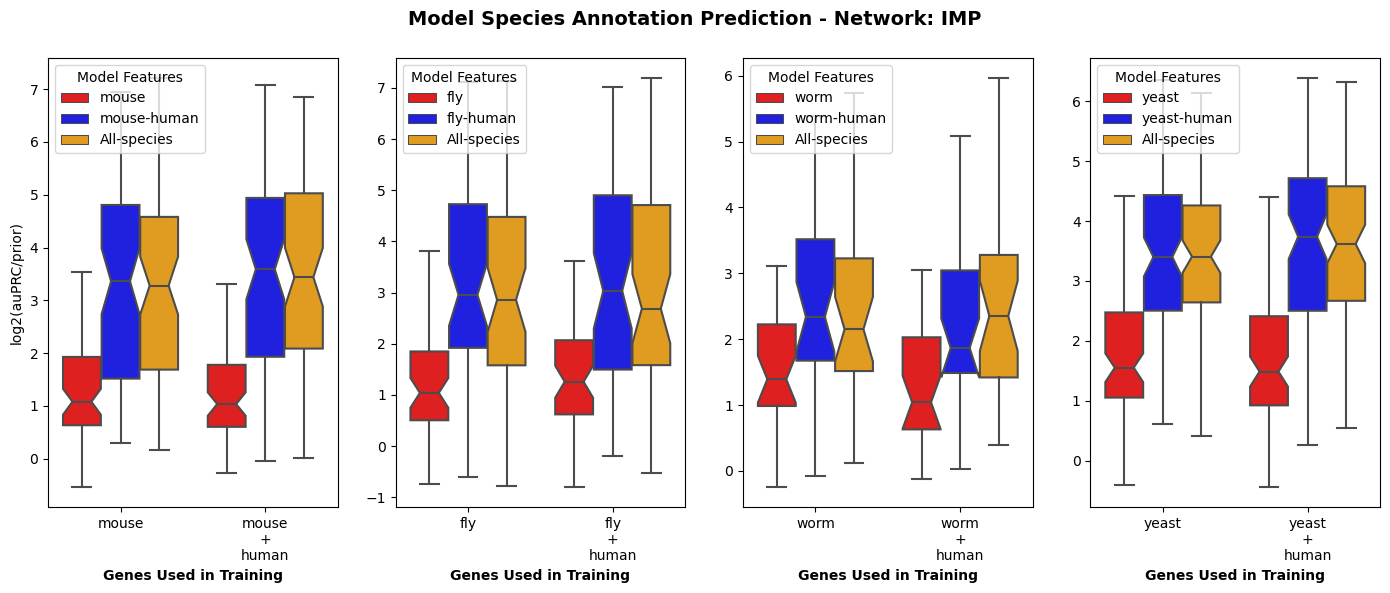

In [5]:
make_plot2("IMP_raw","Pecanpy","mdl","FigSM20.pdf")

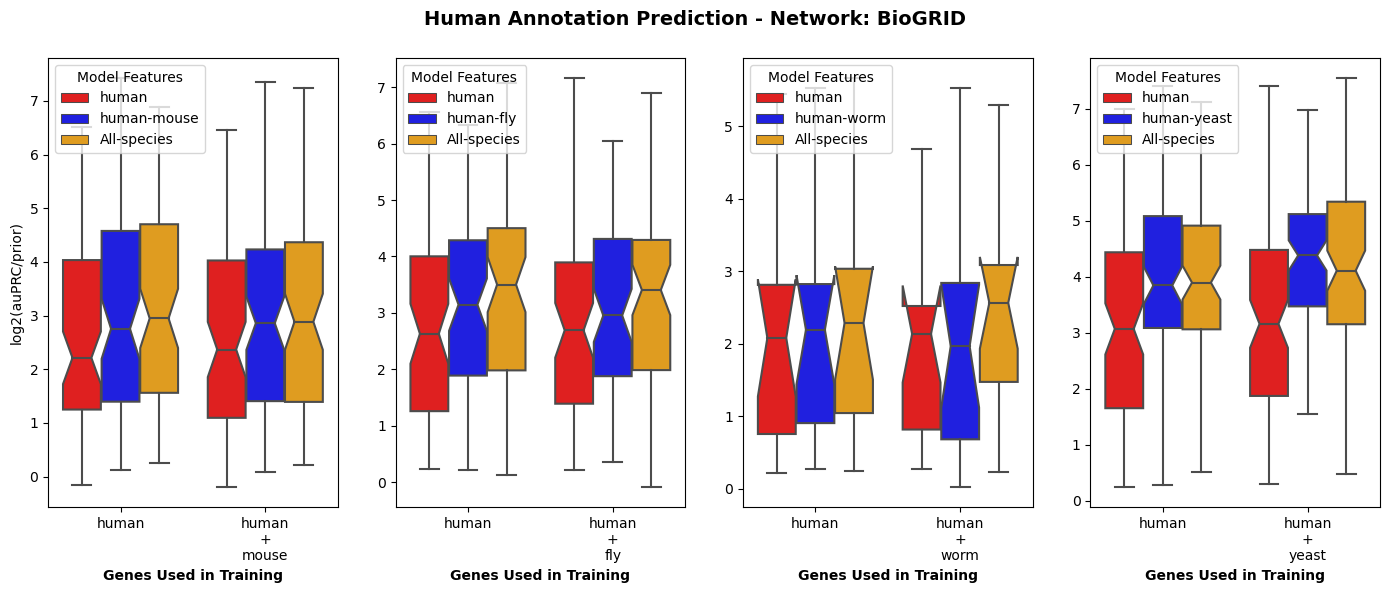

In [6]:
make_plot2("BioGRID_raw","Pecanpy","human","FigSM21.pdf")

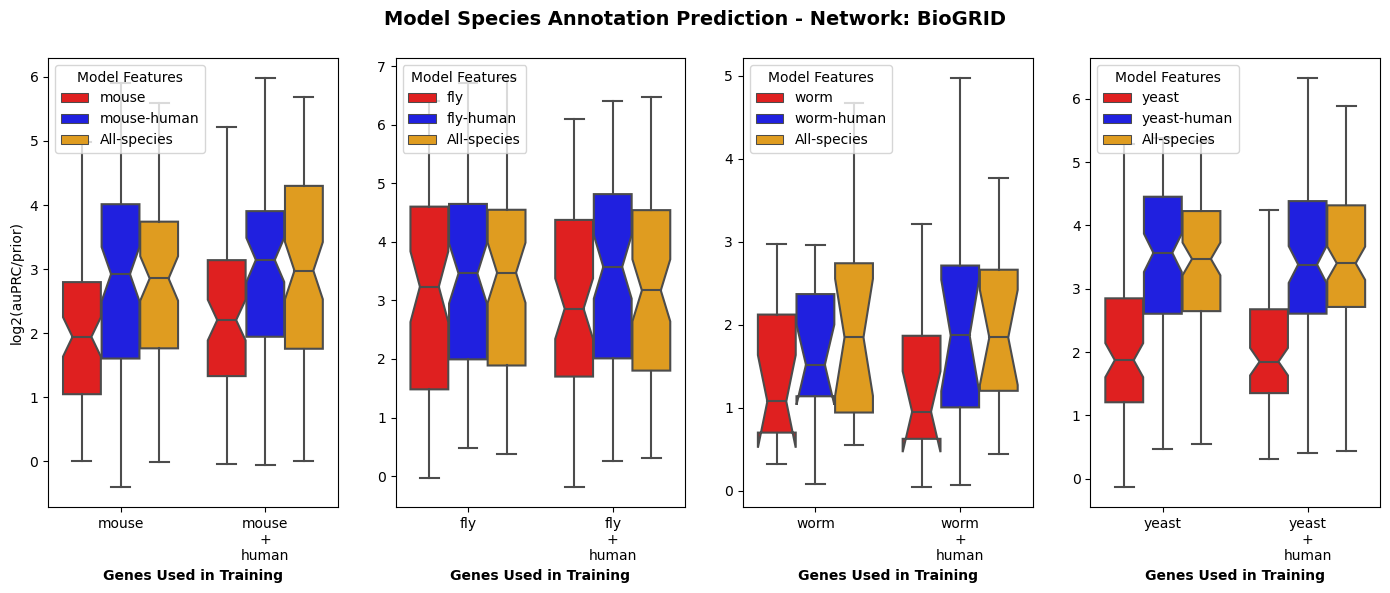

In [7]:
make_plot2("BioGRID_raw","Pecanpy","mdl","FigSM22.pdf")